<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [62]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [63]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [64]:
from google.colab import drive
drive.mount('/content/drive')

INPUT_DIR = ''
data = pd.read_csv(INPUT_DIR + 'train.csv')
X_test = pd.read_csv(INPUT_DIR + 'test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [66]:
# 1 Случайные 3 строчки
data.sample(3, random_state=0)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
4650,66,20.35,1359.5,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Electronic check,0
29,25,89.70,2187.55,Female,1,No,No,Yes,Yes,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,Yes,Electronic check,1
1688,36,76.35,2606.35,Female,0,No,No,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,No,One year,Yes,Mailed check,0


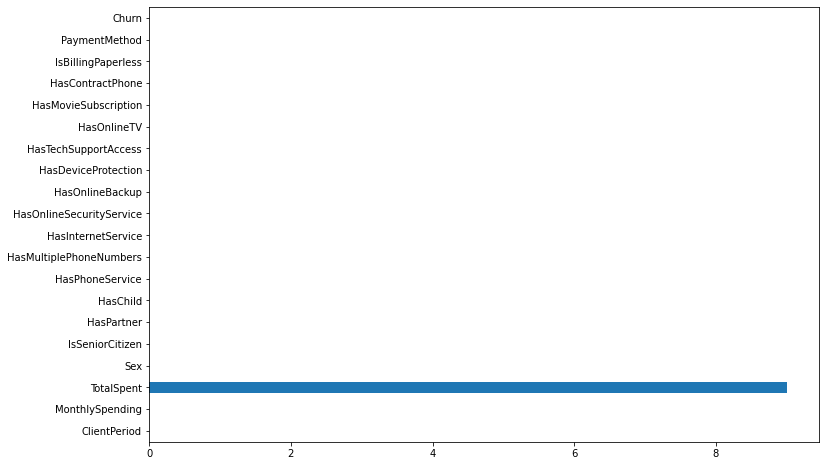

In [67]:
# 2 Замена nan на пропуски и их подсчет
data.replace(" ", np.nan, inplace=True)
X_test.replace(" ", np.nan, inplace=True)
data.isna().sum().plot(kind="barh", legend=False, figsize=(12, 8))
# Заменим nun на 0 
data["TotalSpent"] = data.TotalSpent.fillna(0).astype(float)
X_test["TotalSpent"] = X_test.TotalSpent.fillna(0).astype(float)

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

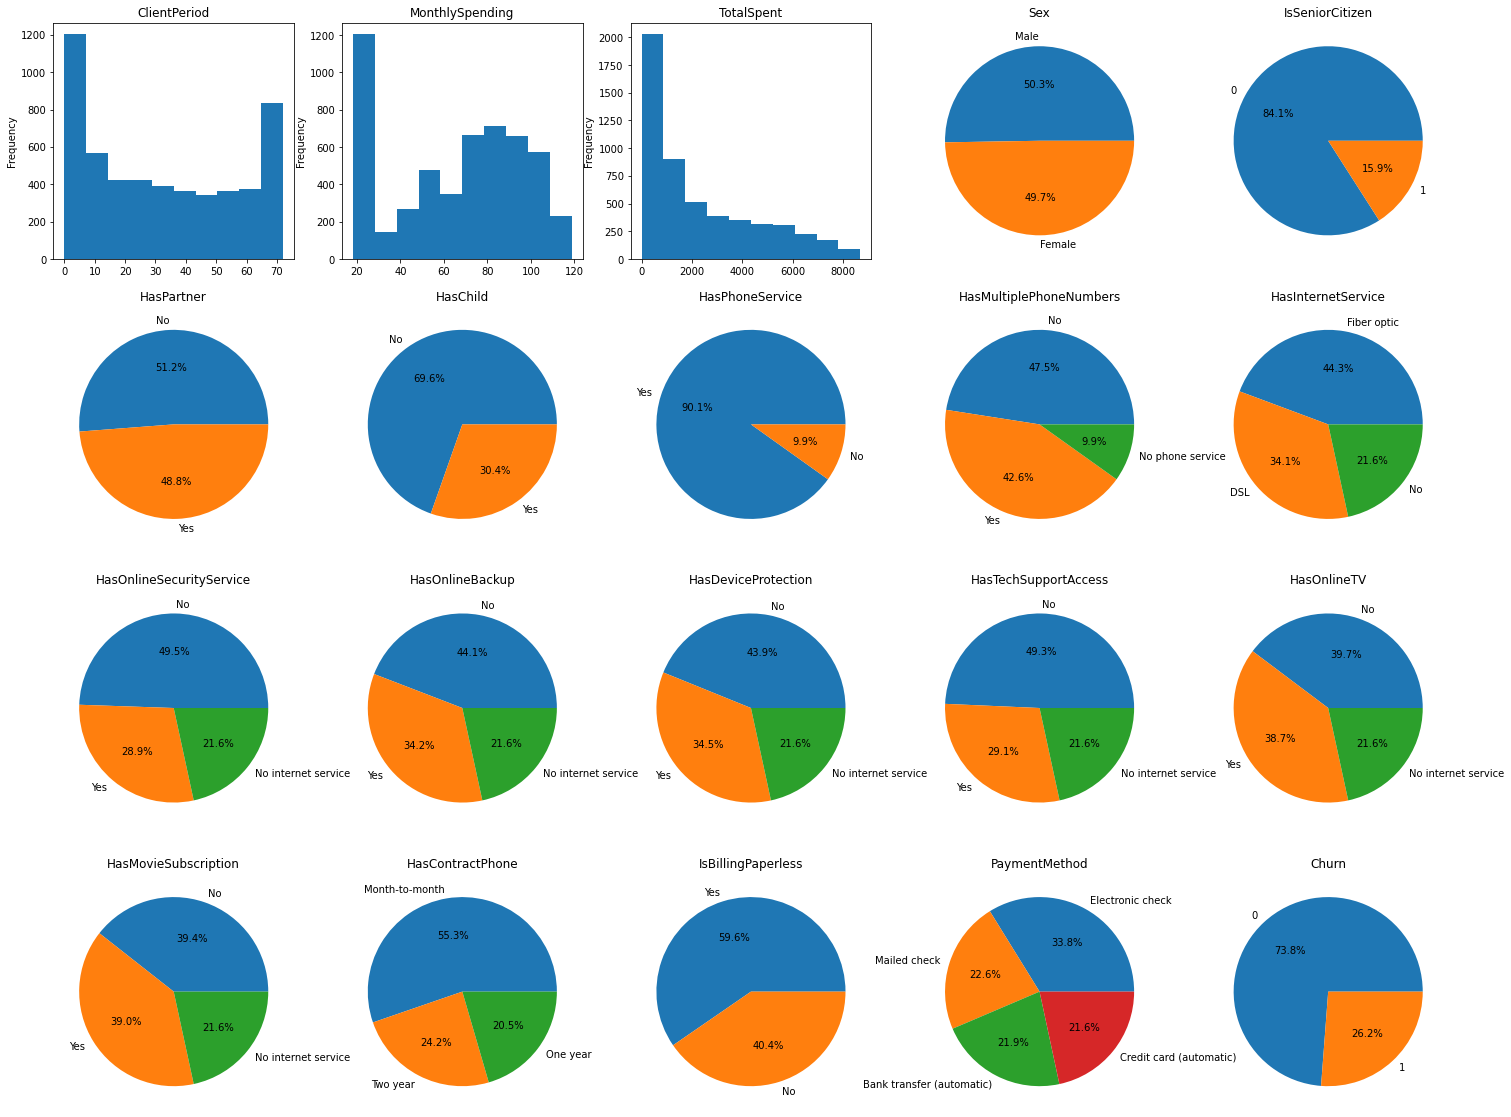

In [68]:
fig , axes = plt.subplots(4, 5, figsize=(25, 20))
for ax, col in zip(axes.flatten(), data.columns):
  ax.set_title(col)
  if col in num_cols:
    data[col].plot(kind = 'hist', ax = ax)
  else:
    ax.pie(data[col].value_counts(), labels = data[col].value_counts().index, autopct = '%1.1f%%')

**Как видно из графика по Churm: перевес класса 0 в 3 раза по сравнению с классом 1.**

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

In [69]:
# 

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [70]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [71]:
# Кодирование признаков:
encode = {
    "No": 0,
    "No internet service": 0,
    "No phone service": 0,
    "Yes": 1,
    "Male": 0,
    "Female": 1,
    "DSL": 1,
    "Fiber optic": 2,
    "Month-to-month": 0,
    "One year": 1,
    "Two year": 2,
    "Credit card (automatic)": 0,
    "Bank transfer (automatic)": 1,
    "Mailed check": 2,
    "Electronic check": 3,
}

X_train = data.replace(encode).drop(target_col, axis  = 1)
y_train = data[target_col]
X_test = X_test.replace(encode)

In [72]:
%%time
from numpy.ma.core import arange
from sklearn.pipeline import Pipeline

# Поиск лучшей модели
# param_grid = {
#     "model__C": [100, 10, 1, 0.1, 0.01, 0.001] 
# }
# clf = Pipeline(steps=[
#     ("scaler", StandardScaler()),
#     ("model", LogisticRegression(random_state=42)),
# ])

# grid_search = GridSearchCV(
#     estimator = clf,
#     param_grid = param_grid,
#     scoring = "roc_auc",
#     n_jobs = -1,
#     cv = 10,
#     refit = True,
# )
# grid_search.fit(X_train, y_train)

#Лучшая модель с параметром С=100

logreg = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=42, C = 100,n_jobs = -1)
)
logreg.fit(X_train, y_train)

submission = pd.read_csv(INPUT_DIR + "submission.csv")
submission["Churn"] = logreg.predict_proba(X_test)[:, 1]
submission.to_csv(INPUT_DIR + "logreg.csv", index=False)



CPU times: user 54.1 ms, sys: 46.7 ms, total: 101 ms
Wall time: 881 ms


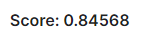

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [73]:
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
# Дефолтный катбуст
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

cat_default = CatBoostClassifier(cat_features = cat_cols)
cat_default.fit(X_train, y_train, verbose=False)
y_predict = cat_default.predict_proba(X_valid)[:, 1]

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

In [75]:
f"ROC-AUC score = {roc_auc_score(y_valid, y_predict)}"

'ROC-AUC score = 0.8429559993536305'

In [86]:
X_train = data.replace(encode).drop(target_col, axis  = 1)
y_train = data[target_col]

catboost = CatBoostClassifier(
    cat_features=cat_cols,
    logging_level="Silent",
    eval_metric="AUC:hints=skip_train~false",
    grow_policy="Lossguide",
    metric_period=1000,
    random_seed=0,
)

param_catboost = {
    "n_estimators": [5, 10, 20, 30, 40, 50, 70, 100, 150, 200, 250, 300, 500, 1000],
    "learning_rate": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.04, 0.05, 0.1, 0.2, 0.3, 0.5],
    "max_depth": np.arange(4, 10, 1)
}
catboost.grid_search(param_catboost, X_train, y_train, cv=5, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.8421630	best: 0.8421630 (0)	total: 119ms	remaining: 1m 59s
1:	loss: 0.8421630	best: 0.8421630 (0)	total: 185ms	remaining: 1m 32s
2:	loss: 0.8421630	best: 0.8421630 (0)	total: 252ms	remaining: 1m 24s
3:	loss: 0.8421845	best: 0.8421845 (3)	total: 351ms	remaining: 1m 28s
4:	loss: 0.8411718	best: 0.8421845 (3)	total: 450ms	remaining: 1m 30s
5:	loss: 0.8434980	best: 0.8434980 (5)	total: 550ms	remaining: 1m 31s
6:	loss: 0.8550074	best: 0.8550074 (6)	total: 628ms	remaining: 1m 29s
7:	loss: 0.8427983	best: 0.8550074 (6)	total: 677ms	remaining: 1m 24s
8:	loss: 0.8578781	best: 0.8578781 (8)	total: 717ms	remaining: 1m 19s
9:	loss: 0.8650240	best: 0.8650240 (9)	total: 757ms	remaining: 1m 15s
10:	loss: 0.8629652	best: 0.8650240 (9)	total: 799ms	remaining: 1m 12s
11:	loss: 0.8670278	best: 0.8670278 (11)	total: 846ms	remaining: 1m 10s
12:	loss: 0.8616779	best: 0.8670278 (11)	total: 925ms	remaining: 1m 10s
13:	loss: 0.8602832	best: 0.8670278 (11)	total: 1000ms	remaining: 1m 10s
14:	loss: 0.

{'params': {'depth': 4, 'iterations': 20, 'learning_rate': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0, 19],
              'test-AUC-mean': [0.7712940545461381, 0.8439714315474383],
              'test-AUC-std': [0.015558622053111213, 0.016808421406142224],
              'train-AUC-mean': [0.7798767892942955, 0.8609987649045354],
              'train-AUC-std': [0.013759662522173033, 0.0029239166570703013],
              'test-Logloss-mean': [0.600845173320862, 0.4164729745328334],
              'test-Logloss-std': [0.0030392913129672003, 0.01774157936720549],
              'train-Logloss-mean': [0.5990515230298327, 0.39701796031994835],
              'train-Logloss-std': [0.004226219698440272,
               0.003697236615711008]})}

# Предсказания

In [90]:
print("Best score:", end=' ')
print(catboost.best_score_)
best_params = catboost.get_params()
print("Best params:", end=' ')
print(best_params)

Best score: {'learn': {'Logloss': 0.4025739784349696, 'AUC': 0.8590265646826445}}
Best params: {'random_seed': 0, 'logging_level': 'Silent', 'metric_period': 1000, 'eval_metric': 'AUC:hints=skip_train~false', 'cat_features': ['Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription', 'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod'], 'grow_policy': 'Lossguide', 'depth': 4, 'iterations': 20, 'learning_rate': 0.2}


In [91]:
submission = pd.read_csv(INPUT_DIR + "submission.csv")
submission["Churn"] = catboost.predict_proba(X_test)[:, 1]
submission.to_csv(INPUT_DIR + "catboost.csv", index=False)

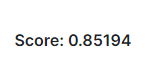

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.